# New York SAT Scores

New York City has published data on student SAT scores by high school, along with additional demographic data sets. Combined the following data sets into a single, clean pandas dataframe:

SAT scores by school - SAT scores for each high school in New York City
School attendance - Attendance information for each school in New York City
Class size - Information on class size for each school
AP test results - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
Graduation outcomes - The percentage of students who graduated, and other outcome information
Demographics - Demographic information for each school
School survey - Surveys of parents, teachers, and students at each school


# Read in the data

In [19]:
import pandas as pd
import numpy 
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [20]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [21]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [22]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [23]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [24]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [25]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [26]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [27]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [28]:
import matplotlib.pyplot as plt
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

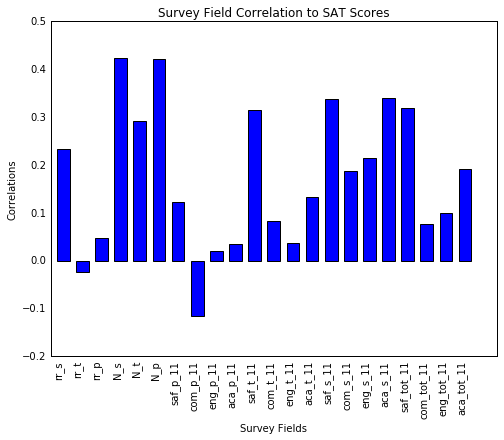

In [29]:
%matplotlib inline
survey_cor = correlations[survey_fields]
fig = plt.figure(figsize=(8,6))
ypos = 3*(numpy.arange(len(survey_cor)))+1
plt.bar(ypos,survey_cor, width=2)
plt.xticks(ypos+0.5, survey_fields, rotation=90)
plt.xlabel('Survey Fields')
plt.ylabel('Correlations')
plt.title('Survey Field Correlation to SAT Scores')
ax = plt.axes()
ax.tick_params(bottom="off", left="off", top="off", right="off" )
plt.show()

saf_t_11 and saf_s_11, which measure how teachers and students perceive safety at school, correlated highly with sat_score.

# Deeper look at safety scores

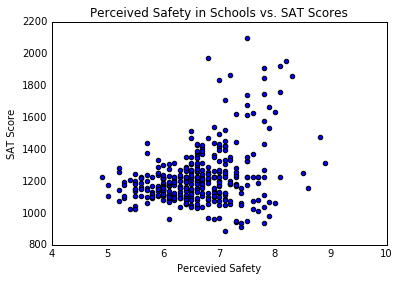

In [30]:
fig = plt.figure(figsize=(6,4))
plt.scatter(combined['saf_s_11'], combined['sat_score'])
plt.xlabel('Percevied Safety')
plt.ylabel('SAT Score')
plt.title('Perceived Safety in Schools vs. SAT Scores')
ax = plt.axes()
ax.tick_params(bottom="off", left="off", top="off", right="off" )

# Mapping safety scores


In [31]:
# Getting the mean safety score by districts
school_safety = combined.groupby("school_dist").agg({'saf_s_11': numpy.mean})
print(school_safety)

# Applying the average school safety score to every column in a district
def get_safety(value):
    school_dist=school_safety.index.tolist()
    saf = school_safety['saf_s_11']
    for i in range(len(school_dist)):
        if school_dist[i] == value:
            return saf[i]
        
combined['school_safety'] = combined['school_dist'].apply(get_safety)


             saf_s_11
school_dist          
01           6.768611
02           6.910660
03           6.716667
04           6.885714
05           6.314286
06           6.950000
07           6.800000
08           6.364697
09           6.655000
10           6.577273
11           6.186667
12           7.116667
13           6.407692
14           6.685714
15           6.177778
16           5.875000
17           6.007143
18           6.190909
19           6.150000
20           7.120000
21           6.390909
22           7.025000
23           6.233333
24           7.107692
25           6.912500
26           6.760000
27           6.390000
28           6.627273
29           6.075000
30           7.033333
31           6.530000
32           6.766667


In [32]:
# Get an average latitude and longitude for each school district
latlon = combined.groupby('school_dist').agg({'lat': numpy.mean, 'lon':numpy.mean})
# Join the average latitute and longitude by district with the average safety score by district
safety_location = school_safety.join(latlon)

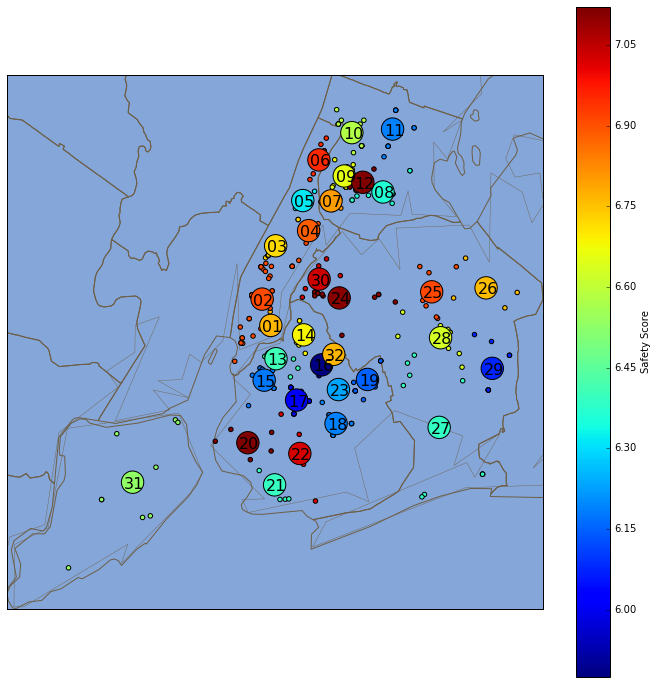

In [33]:
# Creating a map of New York 
from mpl_toolkits.basemap import Basemap
plt.figure(figsize=(12,12))
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

# Drawing the boundaries on the map  
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.drawcounties(color='#6D5F47', linewidth=1)

# Converting latitude and longitude columns to a list 
longitudes = combined['lon'].tolist()
latitudes = combined['lat'].tolist()

# Mapping the school safety established by the district by school location 
s = m.scatter(longitudes, latitudes, s=20, zorder=2, latlon=True, c=combined['school_safety'].tolist())
# Mapping average values by district
dist = safety_location.index.tolist()
long = safety_location['lon'].tolist()
lats = safety_location['lat'].tolist()
s = m.scatter(long, lats , s=500, zorder=2, latlon=True, c=safety_location['saf_s_11'].tolist())
#  Labeling the district scores 
for i, txt in enumerate(dist):
    x, y = m(long[i],lats[i])
    plt.annotate(str(txt),xy=(x-1000,y-750),fontsize=16)
# Adding a legend for the color mapping
cb = plt.colorbar(s)
cb.set_label('Safety Score')
plt.show()

# Race and SAT Scores

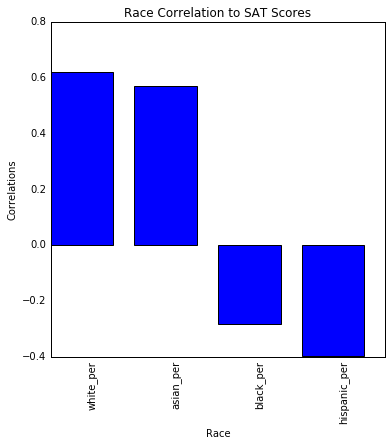

In [34]:
# Creating a list of all race related columns 
races = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
# Subsetting the dataframe by the races list
race_cor = correlations.loc[races]
# Setting the figure size
fig = plt.figure(figsize=(6,6))
# Defining the position of the bars
ypos = 2*(numpy.arange(len(race_cor)))+1
# Creating a bar graph
plt.bar(ypos,race_cor, width=1.5)
# Labeling the graph
plt.xticks(ypos+1, race_cor.index, rotation=90)
plt.xlabel('Race')
plt.ylabel('Correlations')
plt.title('Race Correlation to SAT Scores')
# Grabbing the axes
ax = plt.axes()
# Removing ticks
ax.tick_params(bottom="off", left="off", top="off", right="off" )
plt.show()

There is a strong positive correlation between the percentage of White and Asian individuals per school, a weak negative correlation between the percentage of Blacks per school and a strong negative correlation between the percentage of Hispanics in the school.  

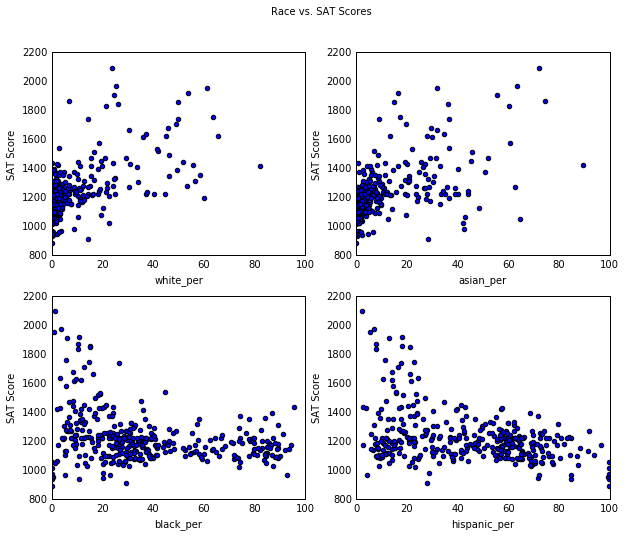

In [75]:
# Setting the figure size
fig = plt.figure(figsize=(10,8))

# Looping through all the values in race to create a scatter plot 
for sp in range(len(races)):
    ax = fig.add_subplot(2, 2, sp+1)
    ax.scatter(combined[races[sp]], combined['sat_score'])
    # Labeling the plots
    ax.set_xlabel(races[sp])
    ax.set_ylabel('SAT Score')
    # Defining strict limits for the plots
    ax.set_xlim(0,100)
    ax.set_ylim(800,2200)
    ax.tick_params(bottom="off", left="off", top="off", right="off" )

# Creating an overall plot title     
plt.suptitle('Race vs. SAT Scores')
plt.show()


As the percentage of hispanics per school increase, the overall SAT Score decreases.    The correlations for whites and asians are more clustered at the low end.  

In [55]:
# Subsetting the data based on race percentage
hispanic = combined[combined['hispanic_per']>95]
# Selecting only the school names 
school_hispanic = hispanic['SCHOOL NAME']
print(school_hispanic)

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The schools with a high percentage of hispanics are primarily schools catering to immigrants who need to learn English.  As the SAT is administered in English, this could decrease the SAT score of anyone not fluent in English.  

In [63]:
# Subsetting the data based on SAT score and the percentage of hispanics 
hispanic_low = combined[(combined['hispanic_per']<10) & (combined['sat_score']>1800)]
# Selecting only the school names 
school_hispanic_low = hispanic_low['SCHOOL NAME']
print(school_hispanic_low)

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The schools with a low percentage of hispanics and high SAT scores are advanced schools specializing in sciences and technical areas.  

# Gender Differences

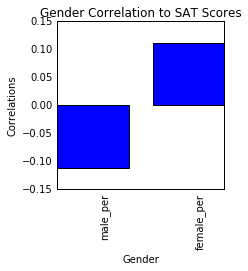

In [65]:
genders = ['male_per','female_per']
# Subsetting the dataframe by the gender list
gender_cor = correlations.loc[genders]
# Setting the figure size
fig = plt.figure(figsize=(3,3))
# Defining the position of the bars
ypos = 2*(numpy.arange(len(gender_cor)))+1
# Creating a bar graph
plt.bar(ypos,gender_cor, width=1.5)
# Labeling the graph
plt.xticks(ypos+1, gender_cor.index, rotation=90)
plt.xlabel('Gender')
plt.ylabel('Correlations')
plt.title('Gender Correlation to SAT Scores')
# Grabbing the axes
ax = plt.axes()
# Removing ticks
ax.tick_params(bottom="off", left="off", top="off", right="off" )
plt.show()

There is a weak negative correlation between the percentage of males in a school and SAT scores, and a weak positive correlation between the percentage of females in a school and SAT scores.  

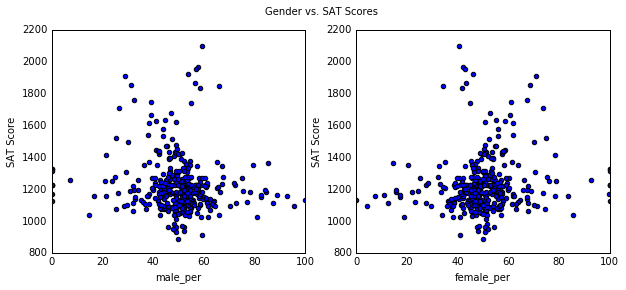

In [76]:
# Setting the figure size
fig = plt.figure(figsize=(10,4))

# Looping through all the values in gender to create a scatter plot 
for sp in range(len(genders)):
    ax = fig.add_subplot(1, 2, sp+1)
    ax.scatter(combined[genders[sp]], combined['sat_score'])
    # Labeling the plots
    ax.set_xlabel(genders[sp])
    ax.set_ylabel('SAT Score')
    # Defining strict limits for the plots
    ax.set_xlim(0,100)
    ax.set_ylim(800,2200)
    ax.tick_params(bottom="off", left="off", top="off", right="off" )

# Creating an overall plot title     
plt.suptitle('Gender vs. SAT Scores')
plt.show()

The figures are direct inverse of each other due to the fact that it gender is a binary value.  

In [71]:
# Subsetting the data based on SAT score and the percentage of females 
female_high = combined[(combined['female_per']>60) & (combined['sat_score']>1700)]
# Selecting only the school names 
school_female_high = female_high['SCHOOL NAME']
print(school_female_high)

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The schools with high percentages of females and high SAT scores are schools geared towards college prep.  

# Advandced Placement (AP) vs. SAT Scores

In the U.S., high school students take Advanced Placement (AP) exams to earn college credit. There are AP exams for many different subjects.

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores.

In [80]:
# Adding a column to the dateframe with the percentage of AP test takers per school
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment'] *100

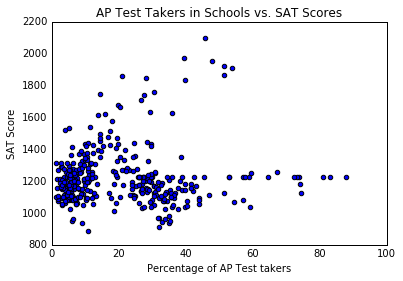

In [81]:
fig = plt.figure(figsize=(6,4))
plt.scatter(combined['ap_per'], combined['sat_score'])
plt.xlabel('Percentage of AP Test takers')
plt.ylabel('SAT Score')
plt.title('AP Test Takers in Schools vs. SAT Scores')
plt.xlim(0,100)
ax = plt.axes()
ax.tick_params(bottom="off", left="off", top="off", right="off" )

There looks to be a weak positive correlation between the number of AP test takers and SAT score.  The percentage of AP test takers does indicate a schools curriculm but does not show the percentage of test takers that passed their respective AP tests.  

# Class Size vs. SAT Scores

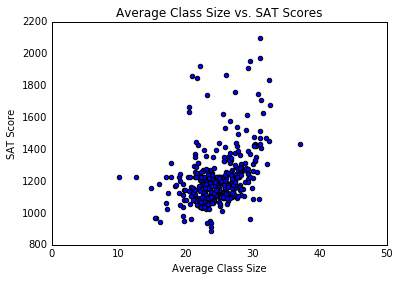

In [84]:
# Setting figure size
fig = plt.figure(figsize=(6,4))
# Creating a scatter plot
plt.scatter(combined['AVERAGE CLASS SIZE'], combined['sat_score'])
# Labeling the plot
plt.xlabel('Average Class Size')
plt.ylabel('SAT Score')
plt.title('Average Class Size vs. SAT Scores')
plt.xlim(0,50)
# Removing tick marks
ax = plt.axes()
ax.tick_params(bottom="off", left="off", top="off", right="off" )

There is a weak positive correlation between the class size and the SAT Score.  This is surprising as schools with smaller classes are thought to be more intimate and successful. 

# Deep Dive - Surveys 

In [85]:
# Grabbing survey names in regards to safety 
safety = ['saf_p_11','saf_t_11','saf_s_11','saf_tot_11']
# Grabbing survey names in regards to academics 
academics = ['aca_p_11','aca_t_11','aca_s_11','aca_tot_11']


## School Safety 

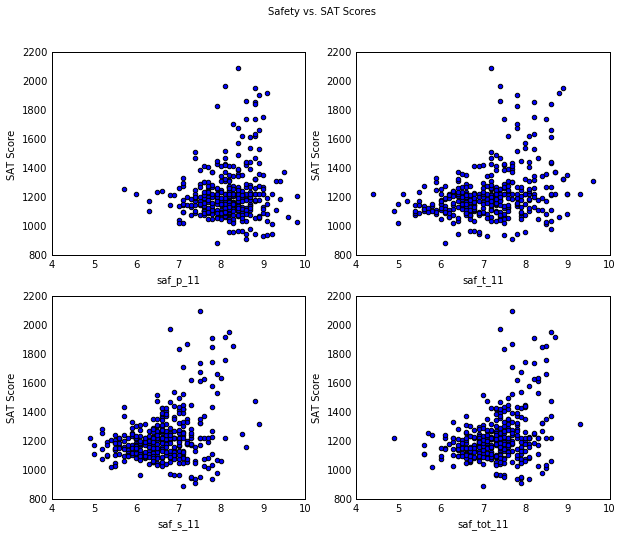

In [88]:
# Setting the figure size
fig = plt.figure(figsize=(10,8))

# Looping through all the values in race to create a scatter plot 
for sp in range(len(safety)):
    ax = fig.add_subplot(2, 2, sp+1)
    ax.scatter(combined[safety[sp]], combined['sat_score'])
    # Labeling the plots
    ax.set_xlabel(safety[sp])
    ax.set_ylabel('SAT Score')
    # Defining strict limits for the plots
    ax.set_xlim(4,10)
    ax.set_ylim(800,2200)
    ax.tick_params(bottom="off", left="off", top="off", right="off" )

# Creating an overall plot title     
plt.suptitle('Safety vs. SAT Scores')
plt.show()


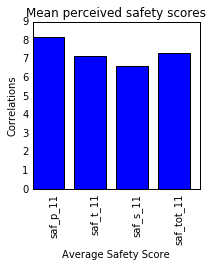

In [103]:
safety_df = combined[safety]
safety_means = safety_df.apply(numpy.mean)

fig = plt.figure(figsize=(3,3))
# Defining the position of the bars
ypos = 2*(numpy.arange(len(safety_means)))+1
# Creating a bar graph
plt.bar(ypos,safety_means, width=1.5)
# Labeling the graph
plt.xticks(ypos+1, safety_means.index, rotation=90)
plt.xlabel('Average Safety Score')
plt.ylabel('Correlations')
plt.title('Mean perceived safety scores')
# Grabbing the axes
ax = plt.axes()
# Removing ticks
ax.tick_params(bottom="off", left="off", top="off", right="off" )
plt.show()

Parents perceived safety was slightly higher than the students perceived safety. Teachers percevied safety was inbetween that of the parents and that of the students, close to the average percevied safety.  

## School Academics

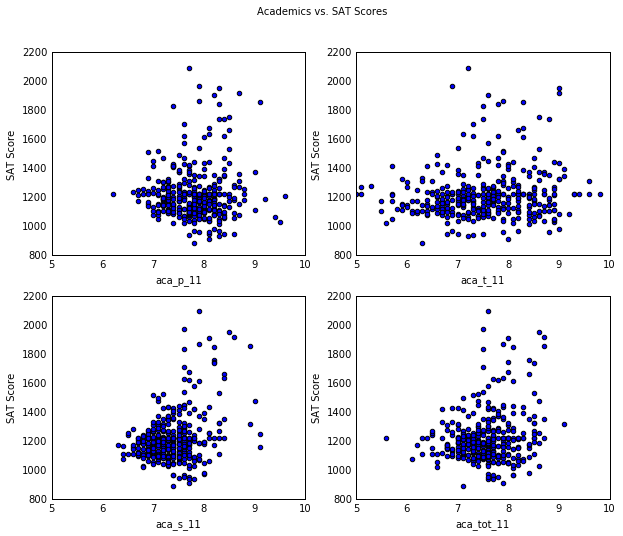

In [102]:
# Setting the figure size
fig = plt.figure(figsize=(10,8))

# Looping through all the values in race to create a scatter plot 
for sp in range(len(academics)):
    ax = fig.add_subplot(2, 2, sp+1)
    ax.scatter(combined[academics[sp]], combined['sat_score'])
    # Labeling the plots
    ax.set_xlabel(academics[sp])
    ax.set_ylabel('SAT Score')
    # Defining strict limits for the plots
    ax.set_xlim(5,10)
    ax.set_ylim(800,2200)
    ax.tick_params(bottom="off", left="off", top="off", right="off" )

# Creating an overall plot title     
plt.suptitle('Academics vs. SAT Scores')
plt.show()


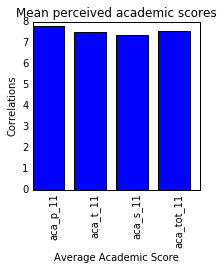

In [105]:
academics_df = combined[academics]
academics_means = academics_df.apply(numpy.mean)

fig = plt.figure(figsize=(3,3))
# Defining the position of the bars
ypos = 2*(numpy.arange(len(academics_means)))+1
# Creating a bar graph
plt.bar(ypos,academics_means, width=1.5)
# Labeling the graph
plt.xticks(ypos+1, academics_means.index, rotation=90)
plt.xlabel('Average Academic Score')
plt.ylabel('Correlations')
plt.title('Mean perceived academic scores')
# Grabbing the axes
ax = plt.axes()
# Removing ticks
ax.tick_params(bottom="off", left="off", top="off", right="off" )
plt.show()

The perceived academic score in the schools between parents, teachers and students are much closer than the percevied safety scores.  

# Future Work

- Figuring out which neighborhoods have the best schools
    - If we combine this information with a dataset containing property values, we could find the least expensive neighborhoods that have good schools.

- Assigning scores to schools based on sat_score and other attributes.